In [1]:
# ========================
# 1. Install dependencies
# ========================
!pip install pandas scikit-learn sentence-transformers umap-learn gspread gspread_dataframe

# ========================
# 2. Load 01_data_cleaning from Google Sheet
# ========================
from google.colab import auth
import gspread
import pandas as pd
from gspread_dataframe import get_as_dataframe
import google.auth

# Google authentication
auth.authenticate_user()
creds, _ = google.auth.default()
gc = gspread.authorize(creds)

# Open spreadsheet (first worksheet)
spreadsheet_id = "13-BxV3gv55YMRQZQiFLbFHjKV1XyQU8Sl71SqsLQ1cQ"
worksheet = gc.open_by_key(spreadsheet_id).get_worksheet(0)
df = get_as_dataframe(worksheet, evaluate_formulas=True)

# Keep only non-empty descriptions
df = df.dropna(subset=["Transaction Description"])
texts = df["Transaction Description"].astype(str).tolist()

# Take the first 300,000 samples
texts = texts[:300000]
print(f"Total descriptions used: {len(texts)}")
print("Sample transaction descriptions:")
print(texts[:10])

# ========================
# 3. Encode descriptions
# ========================
from sentence_transformers import SentenceTransformer

print("\nEncoding descriptions with Sentence-BERT...")
model = SentenceTransformer("all-MiniLM-L6-v2")
X_embed = model.encode(texts, show_progress_bar=True)

# ========================
# 4. Automatic K search (silhouette curve, 5-20)
# ========================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scores = {}
for k in range(5, 21):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_embed)
    score = silhouette_score(X_embed, kmeans.labels_)
    scores[k] = score
    print(f"k={k}, silhouette={score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8,5))
plt.plot(list(scores.keys()), list(scores.values()), marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs K (Encoder embeddings, first 300k samples)")
plt.show()

# Pick the best k
best_k = max(scores, key=scores.get)
print(f"\nBest K based on silhouette: {best_k}")

# ========================
# 5. Final clustering with best K
# ========================
best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_embed)
df_subset = pd.DataFrame({"Transaction Description": texts})
df_subset["Encoder_cluster_bestK"] = best_kmeans.labels_

# ========================
# 6. Run encoder clustering with K=4 (for comparison with Willow)
# ========================
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_embed)
score_k4 = silhouette_score(X_embed, kmeans_k4.labels_)
df_subset["Encoder_cluster_k4"] = kmeans_k4.labels_

print(f"\nEncoder silhouette score at K=4: {score_k4:.4f}")

# ========================
# 7. Visualization with UMAP (K=4 results)
# ========================
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
X_2d = reducer.fit_transform(X_embed)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=df_subset["Encoder_cluster_k4"], cmap="tab20", s=10)
plt.title("UMAP visualization of Encoder embeddings (K=4)")
plt.show()

# ========================
# 8. Show sample results
# ========================
print("\nSample clustering results (first 20 rows):")
print(df_subset[["Transaction Description", "Encoder_cluster_bestK", "Encoder_cluster_k4"]].head(20))

Total descriptions used: 300000
Sample transaction descriptions:
['APPLE.COM/BILL', "LOVE'S #0679 INSIDE", 'CASH APP*ANITA', 'Transfer To *1775', 'AMAZON MKTPL*RK6Y33M30', 'Zelle DANIEL', 'Uber Technologies, Inc', 'SHEETZ 0075   00000752', 'Transfer To 0000', 'Zelle OLAJUMOKE']

Encoding descriptions with Sentence-BERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/9375 [00:00<?, ?it/s]

KeyboardInterrupt: 

k=5, silhouette=0.0486
k=6, silhouette=0.0588
k=7, silhouette=0.0692
k=8, silhouette=0.0675
k=9, silhouette=0.0727
k=10, silhouette=0.0813
k=11, silhouette=0.0880
k=12, silhouette=0.0925
k=13, silhouette=0.0982
k=14, silhouette=0.1009
k=15, silhouette=0.1077
k=16, silhouette=0.1135
k=17, silhouette=0.1213
k=18, silhouette=0.1223
k=19, silhouette=0.1292
k=20, silhouette=0.1343


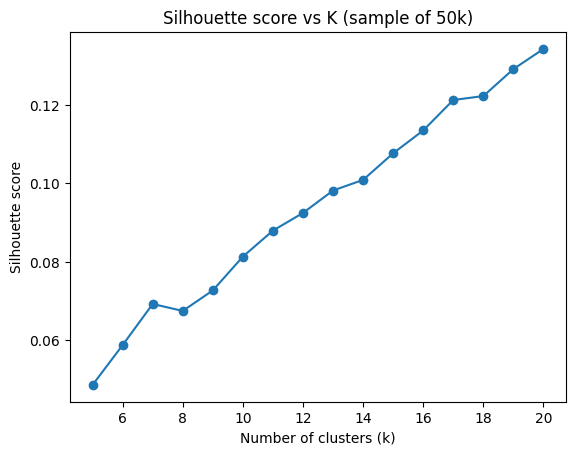


Best k from sample = 20

Sample clustering results (first 20 rows):
   Transaction Description  Encoder_cluster_k4
0           APPLE.COM/BILL                   1
1      LOVE'S #0679 INSIDE                   3
2           CASH APP*ANITA                   1
3        Transfer To *1775                   0
4   AMAZON MKTPL*RK6Y33M30                   3
5             Zelle DANIEL                   0
6   Uber Technologies, Inc                   1
7   SHEETZ 0075   00000752                   3
8         Transfer To 0000                   1
9          Zelle OLAJUMOKE                   0
10                 P489654                   3
11          Acceptance Now                   0
12           To Share 0000                   1
13          37492163950000                   3
14                  0.0491                   3
15                  0.0491                   3
16                  0.0491                   3
17                  0.0491                   3
18           To Share 0000            

In [2]:
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

# ========================
# Step 1: take a sample of 50k for silhouette search
# ========================
sample_size = 50000
idx = np.random.choice(len(X_embed), size=sample_size, replace=False)
X_sample = X_embed[idx]

scores = {}
for k in range(5, 21):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_sample)
    score = silhouette_score(X_sample, kmeans.labels_)
    scores[k] = score
    print(f"k={k}, silhouette={score:.4f}")

# ========================
# Step 2: plot silhouette curve on sample
# ========================
import matplotlib.pyplot as plt
plt.plot(list(scores.keys()), list(scores.values()), marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs K (sample of 50k)")
plt.show()

best_k = max(scores, key=scores.get)
print(f"\nBest k from sample = {best_k}")

# ========================
# Step 3: full 300k clustering with k=4 (MiniBatchKMeans)
# ========================
kmeans_k4 = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=10000).fit(X_embed)
df_subset = pd.DataFrame({"Transaction Description": texts})
df_subset["Encoder_cluster_k4"] = kmeans_k4.labels_

print("\nSample clustering results (first 20 rows):")
print(df_subset.head(20))

In [6]:
# ========================
# Encoder-only clustering (k=4) on 300k transaction descriptions
# ========================

import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Use the first 300k descriptions
texts_300k = texts[:300000]
X_embed_300k = X_embed[:300000]

print("Working on", len(texts_300k), "rows")

# Step 1: clustering with k=4 on the full 300k embeddings
kmeans_k4 = MiniBatchKMeans(
    n_clusters=4, random_state=42, batch_size=10000, n_init=10
).fit(X_embed_300k)
enc_labels_k4 = kmeans_k4.labels_

# Step 2: compute silhouette score on a 50k sample (much faster than using all 300k)
sample_size = 50000
rng = np.random.default_rng(seed=42)
idx = rng.choice(len(X_embed_300k), size=sample_size, replace=False)
sil_sample = silhouette_score(X_embed_300k[idx], enc_labels_k4[idx])
print(f"\nEncoder silhouette score at K=4 (sample 50k): {sil_sample:.4f}")

# Step 3: save results in a DataFrame
df_enc = pd.DataFrame({
    "Transaction Description": texts_300k,
    "Encoder_cluster_k4": enc_labels_k4
})

print("\nCluster sizes (Encoder k=4):")
print(df_enc["Encoder_cluster_k4"].value_counts().sort_index())

# Step 4: show first 10 examples from each cluster
def show_examples(df, col="Encoder_cluster_k4", n=10):
    for c in sorted(df[col].unique()):
        print(f"\nCluster {c} (showing up to {n} examples):")
        ex = df[df[col]==c]["Transaction Description"].head(n).tolist()
        for e in ex:
            print("   ", e)

show_examples(df_enc, "Encoder_cluster_k4", n=10)

Working on 300000 rows

Encoder silhouette score at K=4 (sample 50k): 0.0452

Cluster sizes (Encoder k=4):
Encoder_cluster_k4
0    126314
1     50797
2     75626
3     47263
Name: count, dtype: int64

Cluster 0 (showing up to 10 examples):
    Transfer To *1775
    Zelle DANIEL
    Uber Technologies, Inc
    Zelle OLAJUMOKE
    Acceptance Now
    STATE FARM  INSURANCE
    Zelle MICHEAL
    Zelle MaryEllen
    Zelle JOSEPH
    Zelle ROSE

Cluster 1 (showing up to 10 examples):
    APPLE.COM/BILL
    AMAZON MKTPL*RK6Y33M30
    BEST BUY      00005884
    (CITGO) B&B MINI MART
    JCPENNEY 2802
    Walmart.com
    Amazon Prime*RK31G8BH1
    McDonalds 24527
    PALOTV WAL MART 4643
    TARGET.COM  *

Cluster 2 (showing up to 10 examples):
    LOVE'S #0679 INSIDE
    SHEETZ 0075   00000752
    Transfer To 0000
    P489654
    To Share 0000
    37492163950000
    0.0491
    0.0491
    0.0491
    0.0491

Cluster 3 (showing up to 10 examples):
    CASH APP*ANITA
    Mobile Deposit
    Mobile De

In [7]:
# ========================
# Encoder clustering with k=20 (full 300k)
# ========================

import pandas as pd
from sklearn.cluster import MiniBatchKMeans

# Run clustering with k=20
kmeans_k20 = MiniBatchKMeans(
    n_clusters=20, random_state=42, batch_size=10000, n_init=10
).fit(X_embed_300k)
enc_labels_k20 = kmeans_k20.labels_

# Save results in DataFrame
df_enc_k20 = pd.DataFrame({
    "Transaction Description": texts_300k,
    "Encoder_cluster_k20": enc_labels_k20
})

print("Cluster sizes (Encoder k=20):")
print(df_enc_k20["Encoder_cluster_k20"].value_counts().sort_index())

print("\nSample clustering results (first 20 rows):")
print(df_enc_k20.head(20))

# Optional: show first 10 examples per cluster
def show_examples(df, col="Encoder_cluster_k20", n=10):
    for c in sorted(df[col].unique()):
        print(f"\nCluster {c} (showing up to {n} examples):")
        ex = df[df[col]==c]["Transaction Description"].head(n).tolist()
        for e in ex:
            print("   ", e)

show_examples(df_enc_k20, "Encoder_cluster_k20", n=10)

Cluster sizes (Encoder k=20):
Encoder_cluster_k20
0     10684
1      8934
2     35896
3      3643
4      6675
5     10688
6     52979
7      4858
8      5617
9     11596
10     2381
11     4841
12    24847
13     7008
14     4781
15     1948
16     7466
17    43099
18    42006
19    10053
Name: count, dtype: int64

Sample clustering results (first 20 rows):
   Transaction Description  Encoder_cluster_k20
0           APPLE.COM/BILL                    2
1      LOVE'S #0679 INSIDE                   17
2           CASH APP*ANITA                    0
3        Transfer To *1775                    6
4   AMAZON MKTPL*RK6Y33M30                    5
5             Zelle DANIEL                   16
6   Uber Technologies, Inc                    2
7   SHEETZ 0075   00000752                   13
8         Transfer To 0000                    8
9          Zelle OLAJUMOKE                   16
10                 P489654                   17
11          Acceptance Now                    6
12           To 